In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from alpha_vantage.timeseries import TimeSeries
import requests
import json

In [2]:
def get_daily_data(ticker, start='2020-01-01', end=str(dt.date.today())):
    return yf.download(ticker,start,end)

get_daily_data('SPY').head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,317.873199,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,315.466217,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,316.669739,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,315.779327,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,317.462311,68296000


In [3]:
def get_intraday_data(ticker, interval):
    """Interval: 1min, 5min, 10min"""
    ts = TimeSeries(key='8D6AFPV2LX8VZC1Q', output_format='pandas')
    df, _ = ts.get_intraday(symbol='SPY',interval='1min',outputsize='full')
    df = df.iloc[::-1]
    df.columns = ['Open','High','Low','Close','Volume']
    yesterday = str(dt.date.today()-dt.timedelta(days=1))
    df = df.loc[f'{yesterday} 09:30:00':f'{yesterday} 16:00:00']
    return df

get_intraday_data('SPY', '1min').head()

,Open,High,Low,Close,Volume
date,,,,,


In [4]:
def get_fx_data(instrument,periods,granularity):
    """Returns pandas dataframe of ohlc and volume data"""
    rest_url = "https://api-fxpractice.oanda.com/"
    stream_url = "https://stream-fxpractice.oanda.com/"
    access_token = "7504cc953a3efe6542a1b0181f7a69b0-f5e662a814de4b0d43ea9c206a8e44ce"
    account_id = "101-001-17749174-001"
    authorization_header = {'Authorization':f'Bearer {access_token}','Accept-Datetime-Format':'UNIX', 'Content-type':'application/json'}
    end_point = f"v3/instruments/{instrument}/candles?granularity={granularity}&count={periods}"
    r = requests.get(rest_url+end_point, headers=authorization_header)
    if "errorMessage" in json.loads(r.text).keys():
        print('Error retrieving data')
    else:
        dic = json.loads(r.content)
        candles = dic['candles']
        df = pd.DataFrame()
        df['Open'] = [float(candle['mid']['o']) for candle in candles]
        df['High'] = [float(candle['mid']['h']) for candle in candles]
        df['Low'] = [float(candle['mid']['l']) for candle in candles]
        df['Close'] = [float(candle['mid']['c']) for candle in candles]
        df['Volume'] = [float(candle['volume']) for candle in candles]
        df.index = [dt.datetime.fromtimestamp(float(candle['time'])) for candle in candles]
        return df
get_fx_data('EUR_USD',100,'M1').head()

,Open,High,Low,Close,Volume
2021-06-01 21:49:00,1.22244,1.22250,1.22243,1.22247,74.0
2021-06-01 21:50:00,1.22248,1.22256,1.22246,1.22256,49.0
2021-06-01 21:51:00,1.22254,1.22254,1.22240,1.22240,54.0
2021-06-01 21:52:00,1.22239,1.22242,1.22235,1.22236,31.0
2021-06-01 21:53:00,1.22238,1.22246,1.22238,1.22244,43.0


In [5]:
#Add indicators to data
def Stochastic(df, n=14, m=3):
    df['stoch'] = (df['Close'] - df['Low'].rolling(n).min())/(df['High'].rolling(14).max() - df['Low'].rolling(n).min())*100
    df['stoch_ma'] = df['stoch'].rolling(m).mean()
    
def EMA(df,n):
    df[f'EMA {n}'] = df['Close'].ewm(n,min_periods=n).mean()
    
def RSI(df,n=14):
    "function to calculate RSI"
    df['delta']=df['Close'] - df['Close'].shift(1)
    df['gain']=np.where(df['delta']>=0,df['delta'],0)
    df['loss']=np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    df.drop(columns=['delta', 'gain', 'loss','avg_gain','avg_loss','RS'],inplace = True)
    
def ATR(df,n=14):
    "function to calculate True Range and Average True Range"
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df.drop(['H-L','H-PC','L-PC','TR'],axis=1,inplace=True)

def fractals(df):
    bear_fractals = [np.nan]*len(df)
    bull_fractals = [np.nan]*len(df)
    for i in range(2,len(df)-2):
        high = df['High'][i]
        low = df['Low'][i]

        if high > df['High'][i-1] and high > df['High'][i-2] and high > df['High'][i+1] and high > df['High'][i+2]:
            bear_fractals[i] = df['High'][i]
        if low < df['Low'][i-1] and low < df['Low'][i-2] and low < df['Low'][i+1] and low < df['Low'][i+2]:
            bull_fractals[i] = df['Low'][i]
    df['bull_fractals'] = bull_fractals
    df['bear_fractals'] = bear_fractals

Strategy 1: Hidden divergence with rsi and stochastic

Indicators
- 200 and 50 EMA
- Stochastic
- RSI
- ATR
- Hidden Divergence

Long
- Bullish hidden divergence
- Next bullish stochastic cross
- On cross, if candle closes above 50 and 200 ema go long

Short
- Bearish hidden divergence
- Next bearish stochastic cross
- On cross, if candle closes below 50 and 200 ema go short

Risk
- 1:2 Risk/Reward
- Stop loss below pull back  
- Or stop loss using ATR (Optimize)

Strategy 2: EMA and fractal scalping strategy
- 20,50, and 100 ema
- williams fractal
- Ema's must be in order (20>50>100 or 20<50<100)
- wait for pull back into 20 or 50 ema
- Once pulled back wait for direction fractal
- Place stop loss at 50 if pulled into 20 or 100 if pulled into 50
- 1.5 risk/reward
- Price cannot close below 100 ema

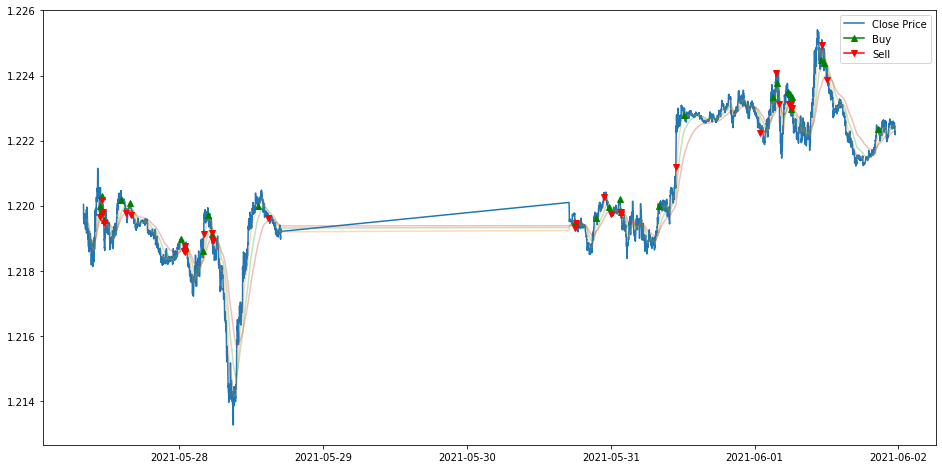

Winners: 11
Losers: 18
Total trades: 29
Winning percentage: 38.0%
Winners in a row: 2
Losers in a row: 4
Gain on account: -1.5%
Span of trades: 5 days 15:27:00


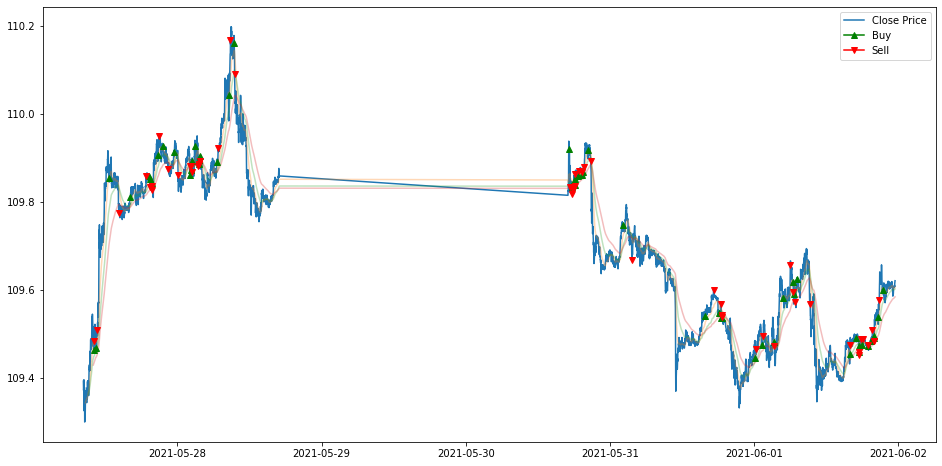

Winners: 28
Losers: 24
Total trades: 52
Winning percentage: 54.0%
Winners in a row: 6
Losers in a row: 3
Gain on account: 18.0%
Span of trades: 5 days 15:07:00


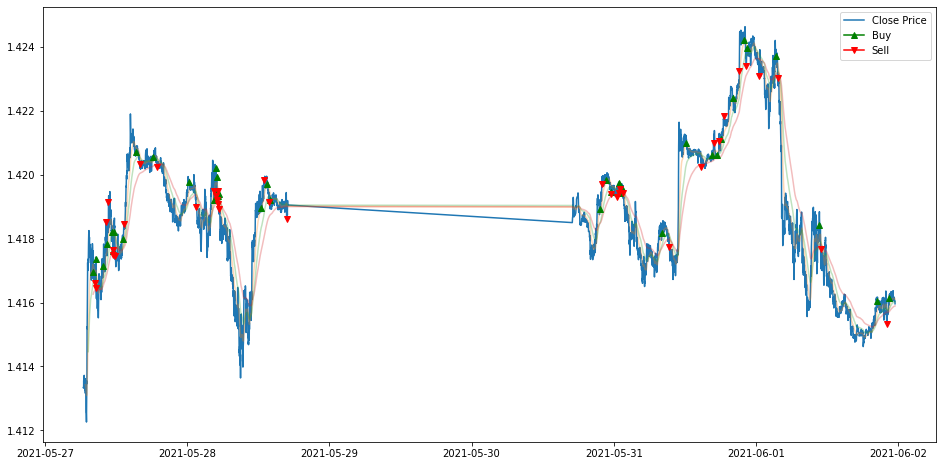

Winners: 13
Losers: 24
Total trades: 37
Winning percentage: 35.0%
Winners in a row: 4
Losers in a row: 5
Gain on account: -4.5%
Span of trades: 5 days 16:58:00


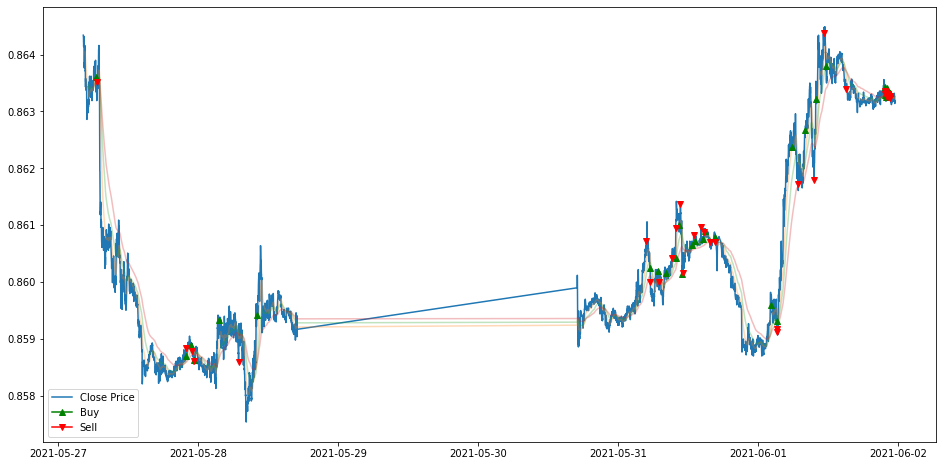

Winners: 13
Losers: 18
Total trades: 31
Winning percentage: 42.0%
Winners in a row: 7
Losers in a row: 6
Gain on account: 1.5%
Span of trades: 5 days 19:09:00


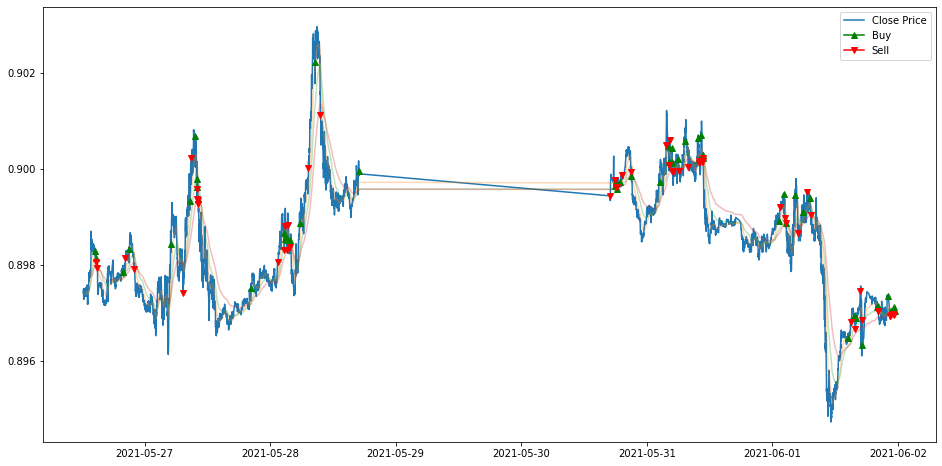

Winners: 19
Losers: 34
Total trades: 53
Winning percentage: 36.0%
Winners in a row: 4
Losers in a row: 8
Gain on account: -5.5%
Span of trades: 6 days 11:13:00


In [7]:
def backtest(df):
    pos = None #Position
    buy = [np.nan]*len(df) #Used for plotting buy signals
    sell = [np.nan]*len(df) #Used for plotting sell signals
    winners = 0 #Total winning trades
    losers = 0 #Total losing trades
    consec_wins = 0 #Current consecutive wins
    consec_losses = 0 #Current consecutive wins
    max_wins = 0 #Most wins in a row
    max_losses = 0 #Most losses in a row
    
    #Variables for strategy
    pullback20 = False
    pullback50 = False
    profit_loss_ratio = 1.5
    for i in range(len(df)-2):
        c = df['Close'][i]
        ema20 = df['EMA 20'][i]
        ema50 = df['EMA 50'][i]
        ema100 = df['EMA 100'][i]
        bull_fractal = not np.isnan(df['bull_fractals'][i-2])

        pullback20 = c < ema20 and c > ema100 and not pos if not pullback20 else True
        pullback50 = c < ema50 and c > ema100 and not pos if not pullback50 else True

        if not pos and (pullback20 or pullback50) and ema20 > ema50 and ema50 > ema100 and bull_fractal:
            stop = ema100 if pullback50 else ema50
            pos = {'buy_price':c,'stop_loss':stop,'take_profit':c + profit_loss_ratio*(c-stop)}
            buy[i] = c
        
        elif pos:
            if c >= pos['take_profit']:
                winners += 1
                consec_wins += 1
                consec_losses = 0
                if consec_wins > max_wins:
                    max_wins = consec_wins
                pos = None
                pullback20 = False
                pullback50 = False
                sell[i] = c
            elif c <= pos['stop_loss']:
                losers += 1
                consec_losses += 1
                consec_wins = 0
                if consec_losses > max_losses:
                    max_losses = consec_losses
                pos = None
                pullback20 = False
                pullback50 = False
                sell[i] = c

    plt.figure(figsize=(16,8))
    plt.plot(df['Close'],label='Close Price')
    plt.plot(df['EMA 20'],alpha=0.3)
    plt.plot(df['EMA 50'],alpha=0.3)
    plt.plot(df['EMA 100'],alpha=0.3)
    plt.plot(df.index,buy,marker='^',color='green',label='Buy')
    plt.plot(df.index,sell,marker='v',color='red',label='Sell')
    plt.legend()
    plt.show()
    print(f'Winners: {winners}')
    print(f'Losers: {losers}')
    print(f'Total trades: {winners + losers}')
    print(f'Winning percentage: {100*round(winners/(winners+losers),2) if winners+losers > 0 else 0}%')
    print(f'Winners in a row: {max_wins}')
    print(f'Losers in a row: {max_losses}')
    print(f'Gain on account: {winners*profit_loss_ratio - losers}%')
    print(f'Span of trades: {df.index[-1]-df.index[0]}')

eur_usd = get_fx_data('EUR_USD',5000,'M1')
EMA(eur_usd,20)
EMA(eur_usd,50)
EMA(eur_usd,100)
fractals(eur_usd)
backtest(eur_usd)

usd_jpy = get_fx_data('USD_JPY',5000,'M1')
EMA(usd_jpy,20)
EMA(usd_jpy,50)
EMA(usd_jpy,100)
fractals(usd_jpy)
backtest(usd_jpy)

gbp_usd = get_fx_data('GBP_USD',5000,'M1')
EMA(gbp_usd,20)
EMA(gbp_usd,50)
EMA(gbp_usd,100)
fractals(gbp_usd)
backtest(gbp_usd)

eur_gbp = get_fx_data('EUR_GBP',5000,'M1')
EMA(eur_gbp,20)
EMA(eur_gbp,50)
EMA(eur_gbp,100)
fractals(eur_gbp)
backtest(eur_gbp)

usd_chf = get_fx_data('USD_CHF',5000,'M1')
EMA(usd_chf,20)
EMA(usd_chf,50)
EMA(usd_chf,100)
fractals(usd_chf)
backtest(usd_chf)